# Visualization of the permittivity in intermediate domain of a solute

This code shows how the behavior of permittivity is displayed with the variable hyperbolic tangent function in a specific solute.

First we import the main libraries such as Numpy, Trimesh, Bempp and Dolfin, as well as files in Python to read the solute files, which is in ".off" format.

In [1]:
import bempp.api
import numpy as np 
import dolfin
from readoff import *
import trimesh
import time
start = time.time()

Next, the physical conditions of the problem in each region are defined, such as pemitivity and the transition slope $k_{p}$ of the hyperbolic tangent.

In [2]:
em = 4.          #[-] Interior electrical permittivity of the solute.
es = 80.         #[-] Exterior electrical permittivity of the solvent.
kp = 6.          #[-] Transition slope of the Hyperbolic Tangent from 0 to infinity. 'N'for kp tending to infinity.

Later we choose the solution we want to display the permittivity.

In [3]:
Mesh1 ="Mobley/Mallas_S/cyclohexanolD8.off"    #Path of the inner surface mesh of the solute for which the energy is to be calculated. In "off" format.
Mesh2 ="Mobley/Mallas_S/cyclohexanolR3D8.off"  #Path of the outer surface mesh of the solute for which the energy is to be calculated. In "off" format.

Next, we generate the surface mesh of the solute.

In [4]:
vertices_0,faces_0 = read_off(Mesh1) 
#In case the mesh has small gaps, with trimesh the information of the original mesh without the gaps is obtained.
meshSP = trimesh.Trimesh(vertices = vertices_0, faces= faces_0) 
mesh_split = meshSP.split()
print("Found %i meshes"%len(mesh_split)) #1 mesh means no cavity.

vertices_1 = mesh_split[0].vertices 
faces_1 = mesh_split[0].faces   
grid1 = bempp.api.grid.grid.Grid(vertices_1.transpose(), faces_1.transpose()) #Creation of the inner surface mesh.

vertices_2 ,faces_2 =read_off(Mesh2) 
grid2 = bempp.api.grid.grid.Grid(vertices_2.transpose(), faces_2.transpose()) #Creation of the outer surface mesh.

Found 1 meshes


Next, we define the following functions to make the final graph, such as, the hyperbolic tangent function, centroid calculation, mapping points in space, finding the intermediate domain and creating the main graph.

In [5]:
#Hyperbolic Tangent Function.
class Fun_S_Antiguo(dolfin.UserExpression): 
    def __init__(self,kp,t,Pa,Pb,**kwargs):
        super().__init__(**kwargs)
        self.Pa = Pa
        self.Pb = Pb
        self.t = t
        self.kp = kp
    def eval(self, v, x): #For a vertex x.
        da = np.linalg.norm(x-self.Pa, axis=1) #Calculate the closest distance with respect to the vertices of the inner mesh.
        db = np.linalg.norm(x-self.Pb, axis=1) #Calculate the closest distance with respect to the vertices of the outer mesh.
        ia = np.argsort(da)[:t] #Search for the vertex with the smallest distance.        
        ib = np.argsort(db)[:t]
        alfa0 = 0    
        for i in range(t): 
            if da[ia[0]]<db[ib[0]]:
                iaa = ia[i]
                ibb = ib[0]
            else:
                ibb = ib[i]
                iaa = ia[0]
            N = np.dot((self.Pa[iaa]-x),(self.Pb[ibb]-self.Pa[iaa])) #Calculate the numerator of the equation to obtain the alpha.
            D = np.linalg.norm(self.Pb[ibb]-self.Pa[iaa], axis=0)**2 #Calculate the denominator of the equation to obtain the alpha.
            alfa0 = alfa0-N/D
        alfa = alfa0/t  #Calculate an average of the alpha with t data with closer distances.
        if kp=='N':     #Optional for the Hyperbolic Tangent function with kp equal to infinity.                
            if alfa<(0.5):
                v[0] = 1
            else:
                v[0] = 0        
        else:
            v[0] = 0.5-0.5*np.tanh(kp*(alfa-0.5))  #Hyperbolic tangent function for kp other than infinity.        
    def value_shape(self):
        return ()  

# Creation of functions for graphics.
def Centroide(grid): #From a surface mesh, the centroid of the mesh is calculated.
    CT =grid.centroids
    Sum1 = 0
    Sum2 = 0
    for i in range(len(CT)):
        Sum1=CT[i]+Sum1
    CTF=Sum1/len(CT)
    return CTF

def Puntos(D0,x,y,z,Nx,Ny,Nz): #Map of points in space, whether 3D or 2D.
    Pt = list()
    if D0=='3D': #3D case.
        for i in range(Nx):
            for j in range(Ny):
                for k in range(Nz):
                    p = [x[i],y[j],z[k]]
                    Pt.append(p)           
    elif D0=='2D': #2D case.
        if len(x)==1: #YZ plane.
            Nx=1
        elif len(y)==1: #XZ plane.
            Ny=1
        else: #XY plane.
            Nz=1
        for i in range(Nx):
            for j in range(Ny):
                for k in range(Nz):
                    p = [x[i],y[j],z[k]]
                    Pt.append(p)
    return Pt

def Ui(A,B): #Function to detect the intermediate domain from logical values.
    F=list()
    for i in range(len(A)):
        a=A[i]
        b=B[i]
        if a==b:
            F.append(True)
        else:
            F.append(False)
    return F   

def Grafico_Global(D0,x,y,z,Nx,Ny,Nz,Malla1,Malla2): #Function to obtain the final permittivity graph.
    global em, es
    Ma = trimesh.load(Malla1, process=False)
    Mb = trimesh.load(Malla2, process=False)
    P0 =  Puntos(D0,x,y,z,Nx,Ny,Nz)
    um_x = Ma.contains(P0)        #Domain m.
    ui1_x = np.logical_not(um_x)
    ui2_x = Mb.contains(P0)
    us_x = np.logical_not(ui2_x)  #Domain s.
    ui_x = Ui(ui1_x,ui2_x)        #Domain i.
    
    #Generate main point mesh.
    if len(x)==1:
        plot_grid = np.mgrid[ymin:ymax:Ny*1j,zmin:zmax:Nz*1j]
        P_Final = np.vstack((np.array([x[0]]*plot_grid[0].size),plot_grid[0].ravel(),plot_grid[1].ravel()))  
    elif len(y)==1:
        plot_grid = np.mgrid[xmin:xmax:Nx*1j,zmin:zmax:Nz*1j]
        P_Final = np.vstack((plot_grid[0].ravel(), np.array([y[0]]*plot_grid[0].size),plot_grid[1].ravel()))                     
    elif len(z)==1:
        plot_grid = np.mgrid[xmin:xmax:Nx*1j,ymin:ymax:Ny*1j]
        P_Final = np.vstack((plot_grid[0].ravel(),plot_grid[1].ravel(),np.array([z[0]]*plot_grid[0].size)))
    else:    
        X0,Y0,Z0 = np.meshgrid(x, y, z)
        P_Final = np.vstack((X0.ravel(),Y0.ravel(),Z0.ravel())) 
    Grafico_Final = np.zeros(P_Final.shape[1], dtype=np.complex128)
     
    #Permittivity case in m.
    Grafico_Final[um_x] += (es+em)/2
    
    #Permittivity case in i.
    P_Fem = P_Final[:, ui_x].transpose()
    Fi_Fem = np.zeros(len(P_Fem))
    for p,point in enumerate(P_Fem):
        result = np.zeros(1)
        S.eval(result, point)
        Fi_Fem[p] = em*result[0]+(1-result[0])*es         
    Grafico_Final[ui_x] += Fi_Fem

    #Permittivity case in s.
    Grafico_Final[us_x] += (es+em)/2

    if D0=='3D':
        Grafico_Final = Grafico_Final.reshape((Nx, Ny, Nz))
    elif D0=='2D':
        if len(x)==1:
            Grafico_Final = Grafico_Final.reshape((Ny, Nz))
            Grafico_Final = Grafico_Final.transpose()[::-1]
        elif len(y)==1:
            Grafico_Final = Grafico_Final.reshape((Nx, Nz))
            Grafico_Final = Grafico_Final.transpose()[::-1]
        elif len(z)==1:
            Grafico_Final = Grafico_Final.reshape((Ny, Nz))
            Grafico_Final = Grafico_Final.transpose()[::-1] 
    return Grafico_Final

We execute all the functions to generate the final graph, including the position of the solute cut, which in this case, is a cut in the XY plane at the Z position to be determined.

In [6]:
%matplotlib inline
#Information to calculate the Hyperbolic Tangent function.
Pa = grid1.centroids
Pb = grid2.centroids
t=3
S = Fun_S_Antiguo(kp,t,Pa,Pb,degree=0)  

CTF = Centroide(grid1) #Centroids.
FR=8  #Limit of the graph from the centroid.
xmin, xmax, ymin, ymax =[int(CTF[0]-FR), int(CTF[0]+FR) ,int(CTF[1]-FR),int(CTF[1]+FR)] 

#XY Plane Graph.
Nx0,Ny0,Nz0 = [250,250,250] 
x0 = np.linspace(xmin, xmax, Nx0)
y0 = np.linspace(ymin, ymax, Ny0)
zf0=[CTF[2]]
print("Z is:{:5.3f}[Å]".format(zf0[0]))   
Grafico_Final_2D = Grafico_Global('2D',x0,y0,zf0,Nx0,Ny0,Nz0,Mesh1,Mesh2) 

Z is:-0.497[Å]


Finally, we visualize the cutoff of the solute permittivity behavior.

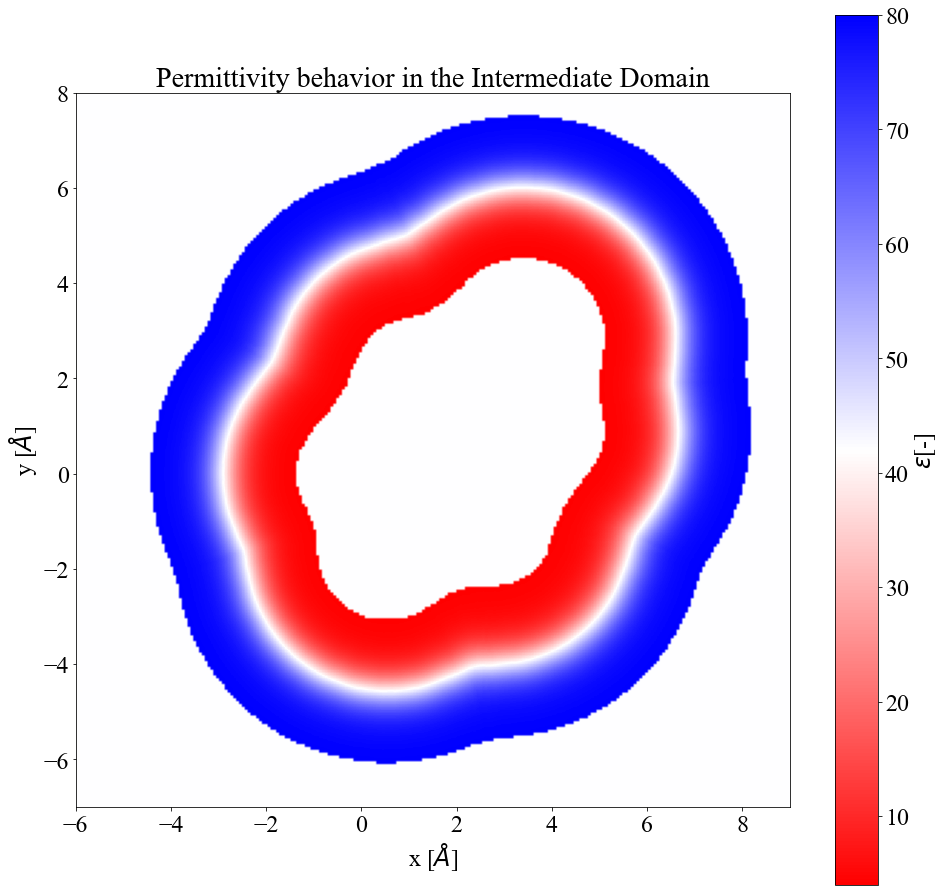

Tiempo total: 119.96 [s]


In [7]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16, 16)
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.imshow(np.real(Grafico_Final_2D), extent=[xmin, xmax, ymin, ymax], cmap='bwr_r', vmin=4, vmax=80)
plt.xlabel('x [$\AA$]')
plt.ylabel('y [$\AA$]')
bar = plt.colorbar()
bar.set_label('$\epsilon$[-]') 
plt.title("Permittivity behavior in the Intermediate Domain",fontsize = 28)
#plt.savefig('GraficosT/eps_Mobley')
plt.show()

end = time.time()
curr_time = (end - start)   
print("Total time: {:5.2f} [s]".format(curr_time))